# Generate new text
We want to predict

$$\hat{P}(w_i \mid w_1, \dots, w_{i-1})$$

In order to exploit the probability distribution $\phi(V)$ over the vocabulary that is used to predict the next word as a tool for extracting the next word during the text generation process.

In [15]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

In [16]:
import string
import nltk
import matplotlib.pyplot as plt

## Case study
We aim at training a network for a Movie in the Movie-Dialog dataset. Instead of using simple tokens, we create artificial tokens by combining a token with its part-of-speech.

In [3]:
from langmodels.corpora.moviedialog import MovieDialogCollection

## Word embeddings
Since we do not have single words, but words plus POS, we cannot use a pre-trained word embedding model. Thus, we create one custom model, using a larger corpus (see the [example](https://github.com/afflint/inforet/blob/master/thematic-studies/language-models/L04-wordembeddings.ipynb))

In [5]:
genre = ['western']
ug = {'$unwind': '$character.movie.genres'}
mg = {'$match': {'character.movie.genres': {'$in': genre}}}
pg = {'$project': {'_id': 0, 'id': 1, 'text': 1}}
pipeline = [ug, mg, pg]

In [7]:
db_name = 'movie-dialogs'
collection = 'lines'

In [8]:
corpus = MovieDialogCollection(db_name, collection, 
                                use_pos=False, 
                                mix_pos=True, pipeline=pipeline)

### Word embedding

In [10]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

In [11]:
embedding_model = Word2Vec.load('../../data/token_pos.word2vec')

### Create an embedding matrix for feeding the network
For each word in dataset’s vocabulary, we check if it is on Word2Vec vocabulary. If it do it, we load its pre-trained word vector. Otherwise, we initialize a random vector. Moreover, we add two special random vectors for the start sentence token `#S` and the end token `#E`.

In [12]:
V = corpus.vocabulary + ['#S', '#E']

In [13]:
word2idx = dict([(w, i) for i, w in enumerate(V)])

In [17]:
embedding_matrix = np.zeros((len(V), embedding_model.vector_size))
for word, i in word2idx.items():
    try: 
        embedding_matrix[i] = embedding_model.wv[word]
    except KeyError:
        embedding_matrix[i] = np.random.normal(size=(embedding_model.vector_size, ))

**Check**

In [18]:
embedding_model.wv['he_PRON'] - embedding_matrix[word2idx['he_PRON']]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Create a model embedding layer
We now create an embedding layer to be used as input for the network. This is non trainable, because we already have fitted it with the pre-trained word embedding model.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

In [20]:
def create_emb_layer(embedding_matrix, non_trainable=True):
    num_embeddings, embedding_dim = embedding_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.tensor(embedding_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim

In [21]:
E = create_emb_layer(embedding_matrix, non_trainable=True)

## Create a simple NGram language model
Simple example taken from [pytorch tutorials](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)

In [70]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, emb_matrix, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder, num_embeddings, embedding_dim = create_emb_layer(emb_matrix, non_trainable=True)
        self.gru = nn.GRU(embedding_dim, hidden_size, n_layers, batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.output = nn.LogSoftmax(dim=1)
    
    def forward(self, input_data, hidden):
        input_data = self.encoder(input_data.view(1, -1))
        output, hidden = self.gru(input_data.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        output = self.output(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [110]:
model = RNN(input_size=len(V), hidden_size=64, output_size=len(V), emb_matrix=embedding_matrix, n_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss = nn.NLLLoss()

### Understand the input

In [46]:
training_set = []
for _, tokens in corpus.get_tokens():
    for a, b, c in nltk.ngrams(tokens, n=3):
        training_set.append(([a, b], [c]))

In [47]:
training_set[0]

(['now_ADV', 'you_PRON'], ['tell_VERB'])

In [48]:
def prepare(tokens):
    return torch.tensor([word2idx[w] for w in tokens], dtype=torch.long)

In [49]:
p = prepare(training_set[0][0])

In [50]:
p

tensor([3411, 4550])

In [51]:
p[0].view(1, -1)

tensor([[3411]])

## Train
- Create input and target tensors
- Create a zeroed initial hidden state
- Read each word input and **keep hidden state** for next word
- Compare final output to target
- Back-propagate
- Return the output and loss

In [111]:
epochs = tqdm_notebook(list(range(30)))
losses = []
limit = 1000 # just to speed up things in the examples
for epoch in epochs:
    total_loss = 0
    for context_words, target_word in training_set[:limit]:
        hidden = model.init_hidden()
        model.zero_grad()
        context, target = prepare(context_words), prepare(target_word)
        for i in range(context.size()[0]):
            output, hidden = model(context[i], hidden)
        error = loss(output, target)
        error.backward()
        total_loss += error.item()
    losses.append(total_loss)

In [112]:
import matplotlib.pyplot as plt

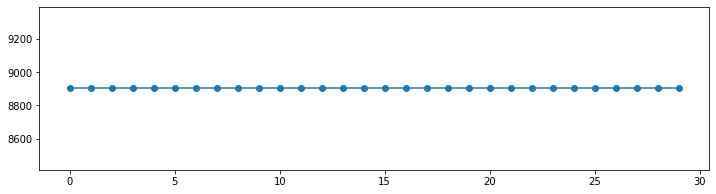

In [113]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(losses, marker='o')
plt.show()

In [114]:
prediction, hidden = model(prepare(['#S']), model.init_hidden())

In [115]:
prediction

tensor([[-8.8745, -8.6447, -9.1027,  ..., -9.0204, -8.5116, -8.8660]],
       grad_fn=<LogSoftmaxBackward>)

In [116]:
V[prediction.argmax().item()]

'reward_NOUN'

In [117]:
def generate(start='#S', max_len=5):
    text = [start]
    for w in range(max_len):
        prediction, hidden = model(prepare([text[-1]]), model.init_hidden())
        next_word = np.random.choice(V, p=np.exp(prediction.detach().numpy()[0]))
        text.append(next_word)
        if next_word == '#E':
            break
    return text

In [118]:
generate()

['#S', 'cares_VERB', 'smile_NOUN', 'bust_NOUN', 'killin_NOUN', 'haired_ADJ']